# Bandpass temperature difference with t-test

## Import package

In [38]:
import numpy as np
import joblib as jl
import netCDF4 as nc

from scipy.stats import t
from matplotlib.colors import TwoSlopeNorm
from matplotlib import pyplot as plt

## Load data

In [39]:
# Load temperature PC data
dims: dict[str, np.ndarray] = dict()
temp: dict[str, np.ndarray] = dict()

with nc.Dataset("/work/b11209013/2024_Research/MPAS/PC/CNTL_PC.nc", "r") as f:
    for key in f.dimensions.items():
        dims[key[0]] = f.variables[key[0]][:]

    temp["CNTL"] = (f.variables["t"][:2].mean(axis=2))

with nc.Dataset("/work/b11209013/2024_Research/MPAS/PC/NCRF_PC.nc", "r") as f:
    temp["NCRF"] = (f.variables["t"][:2].mean(axis=2))

lmode, llon, ltime = temp["NCRF"].shape

# load EOf structure
with nc.Dataset("/work/b11209013/2024_Research/MPAS/PC/EOF.nc", 'r') as f:
    lev = f.variables["lev"][:]
    eof = f.variables["EOF"][:2].T
    
print("CNTL temp shape:", temp["CNTL"].shape)

# load events
lon_ref: dict[str, np.ndarray] = dict()
time_ref: dict[str, np.ndarray] = dict()

for key in temp.keys():
    lon_ref[key], time_ref[key] = np.load(
        f"/home/b11209013/2024_Research/MPAS/Composite/Q1_event_sel/Q1_sel/{key}.npy"
    )

CNTL temp shape: (2, 720, 376)


### Construct 3D data

In [40]:
temp_3d: dict[str, np.ndarray] = dict()

temp_3d["CNTL"] = (np.array(eof) @ np.array(temp["CNTL"]).reshape(2, -1)).reshape(38, temp["CNTL"].shape[1], temp["CNTL"].shape[2]).transpose(2, 0, 1)
temp_3d["NCRF"] = (np.array(eof) @ np.array(temp["NCRF"]).reshape(2, -1)).reshape(38, temp["NCRF"].shape[1], temp["NCRF"].shape[2]).transpose(2, 0, 1)

temp_ano: dict[str, np.ndarray] = dict()

temp_ano["CNTL"] = temp_3d["CNTL"] - temp_3d["CNTL"].mean(axis=(0, 2))[None, :, None]
temp_ano["NCRF"] = temp_3d["NCRF"] - temp_3d["NCRF"].mean(axis=(0, 2))[None, :, None]

print("Anomaly CNTL temp shape:", temp_ano["CNTL"].shape)


Anomaly CNTL temp shape: (376, 38, 720)


## Systematic Event selection

### Time interval setting

In [41]:
time_itv: dict[str, np.ndarray] = dict()

for key in temp.keys():
    time_itv[key] = np.array([
        np.linspace(time_ref[key][i]-12, time_ref[key][i]+12, 25)
        for i in range(time_ref[key].shape[0])
    ])


### Event selection

In [42]:
temp_sel: dict[str, np.ndarray] = dict()

for key in temp.keys():
    temp_sel[key] = np.array([
        temp_ano[key][time_itv[key][i].astype(int), :, lon_ref[key][i].astype(int)]
        for i in range(time_ref[key].shape[0])
    ])

temp_diff: np.ndarray = (temp_sel["CNTL"].mean(axis=0) - temp_sel["NCRF"].mean(axis=0))
print("temp_diff shape:", temp_diff.shape)

temp_diff shape: (25, 38)


## Bootstrapping

### Generate random points

In [43]:
# generate random points
lon_rand : np.ndarray = np.random.randint(0, llon-1, 26000).reshape(1000, 26)
time_rand: np.ndarray = np.random.randint(13, ltime-13, 26000)

# setting time interval
time_itv_rand: np.ndarray = np.array([
    np.linspace(time_rand[i]-12, time_rand[i]+12, 25, dtype=int)
    for i in range(time_rand.shape[0])
]).reshape(26, 1000, 25).transpose(1, 0, 2)

print("Random lon size:", lon_rand.shape)
print("Random time interval size:", time_itv_rand.shape)

Random lon size: (1000, 26)
Random time interval size: (1000, 26, 25)


### Select random events

In [44]:
temp_diff_rand: np.ndarray = np.empty((1000, 38, 25))

for i in range(time_itv_rand.shape[0]):
    
    temp_CNTL = np.array([
        temp_ano["CNTL"][time_itv_rand[i, j].astype(int), :, lon_rand[i, j].astype(int)].T
        for j in range(time_itv_rand.shape[1])
    ]).mean(axis=0)
    
    temp_NCRF = np.array([
        temp_ano["NCRF"][time_itv_rand[i, j].astype(int), :, lon_rand[i, j].astype(int)].T
        for j in range(time_itv_rand.shape[1])
    ]).mean(axis=0)
    
    temp_diff_rand[i] = temp_CNTL - temp_NCRF
print("Random temperature difference shape:", temp_diff_rand.shape)

Random temperature difference shape: (1000, 38, 25)


## Statistic test

(25, 38)


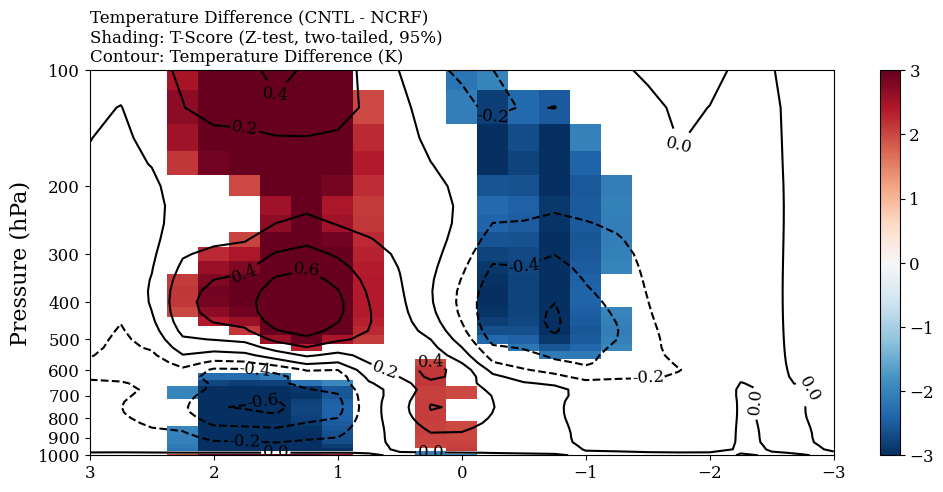

In [48]:
# mean and standard deviation
temp_diff_mean: np.ndarray = temp_diff_rand.mean(axis=0).T
temp_diff_std : np.ndarray = temp_diff_rand.std(axis=0).T


temp_diff_t: np.ndarray = (temp_diff - temp_diff_mean) / temp_diff_std

temp_diff_t = np.where(np.abs(temp_diff_t) > 1.96, temp_diff_t, np.nan)

plt.rcParams.update({
    'font.size': 12,
    'figure.titlesize': 18,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'font.family': 'serif',
})
print(temp_diff_t.shape)
plt.figure(figsize=(12, 5))
cf = plt.pcolormesh(np.linspace(-3, 3, 25), lev, temp_diff_t.T, cmap="RdBu_r", norm=TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3))
c = plt.contour(np.linspace(-3, 3, 25), lev, temp_diff.T, colors="black")
plt.yscale("log")
plt.yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10, dtype=int))
plt.xlim(-3, 3)
plt.ylim(100, 1000)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.ylabel("Pressure (hPa)")
plt.title("Temperature Difference (CNTL - NCRF)\nShading: T-Score (Z-test, two-tailed, 95%)\nContour: Temperature Difference (K)", fontsize=12, loc="left")
plt.clabel(c, inline=True, fmt="%.1f")
plt.colorbar(cf)
plt.savefig("temp_diff_t_score.png", dpi=300)

### Temperature Profile

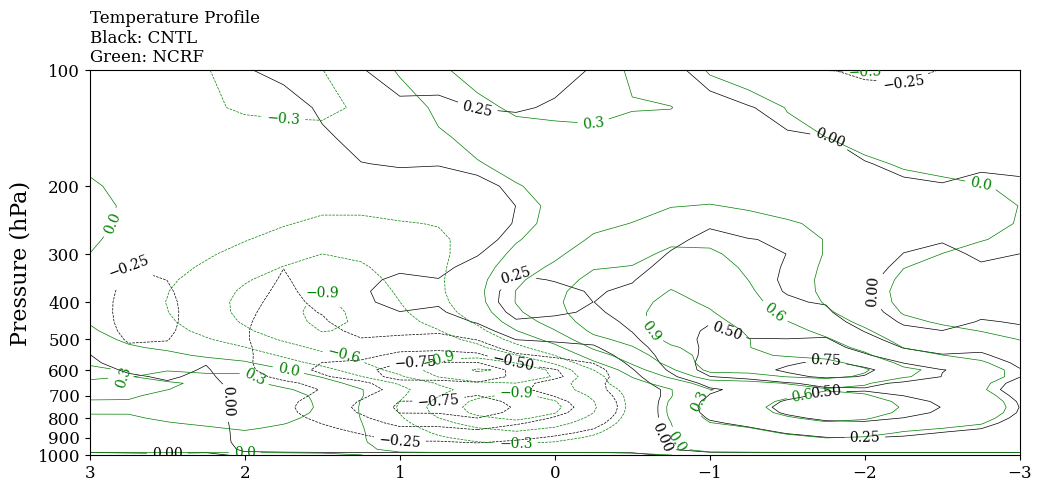

In [49]:
plt.figure(figsize=(12, 5))
c_cntl = plt.contour(np.linspace(-3, 3, 25), lev, temp_sel["CNTL"].mean(axis=0).T, colors="black", linewidths=0.5)
c_ncrf = plt.contour(np.linspace(-3, 3, 25), lev, temp_sel["NCRF"].mean(axis=0).T, colors="green", linewidths=0.5)
plt.yscale("log")
plt.yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10, dtype=int))
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.ylabel("Pressure (hPa)")
plt.title("Temperature Profile\nBlack: CNTL\nGreen: NCRF", fontsize=12, loc="left")
plt.clabel(c_cntl, inline=True, fontsize=10)
plt.clabel(c_ncrf, inline=True, fontsize=10)
plt.savefig("Composite_temp_profile.png", dpi=300)